**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio1210\\cplex\\python\\3.7\\x64_win64\\cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Parameters

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_init_conf =     '../output/m20-improved-4.csv'
path_dump_improved = '../output/m20-improved-5.csv' # output solution

num_cpu_cores = 20
#time_limit = -1 # unlimited
time_limit = 4*24*60*60  # in s

occupancy_diff = 200  # +- the occupancy of input solution for each day
occupancy_diff_low = 10  # +- the occupancy of input solution for each day
max_family_rank = 7  # maximum number of rank of the preference days for each family
use_hint = True      # use current input as hint
occupancy_count_as_variables = False  # use occupancy_counts as variable (seem faster)
redundant_occupancy_constraints = True  # use redundant constraints
min_choice_0_families = 3742   # minimum number of families that are at their choice 0
target_pref_cost = 0 # 62868
target_pref_cost_error = 0
target_pref_cost_lower = 62867
target_accounting_cost = 0 # 6020.043432
target_accounting_cost_error = 0
target_accounting_cost_lower = 5554
max_accounting_cost_per_day = 500

In [4]:
N_families - 62868 / 50

3742.6400000000003

In [5]:
families = range(N_families)
days = range(1, N_days + 1)

In [6]:
#print(list(days))

In [7]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [8]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     69670.75326088161
Preference cost: 64092
Accounting cost: 5578.753260881604


In [9]:
print(occupancy, occupancy.shape)

[125 300 288 300 300 285 263 249 249 269 296 300 297 273 262 258 273 296
 290 274 247 223 228 256 283 300 292 273 262 251 246 275 275 256 224 195
 167 192 227 251 236 206 176 160 125 294 276 251 219 188 156 125 282 260
 231 195 160 127 125 263 238 205 163 125 125 125 246 219 183 139 125 125
 125 225 206 175 128 125 125 125 229 211 181 138 126 125 125 253 231 199
 157 125 125 125 225 204 171 126 125 125 125 125] (102,)


In [10]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

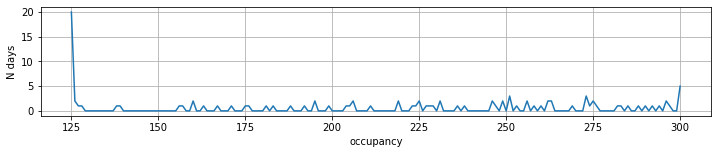

In [11]:
plt.figure(figsize=(12, 2))
plt.plot(init_occupancy_counts); plt.xlabel('occupancy'); plt.ylabel('N days')
plt.ylim(-1, init_occupancy_counts.max()+1); plt.grid(); plt.show()

In [12]:
accounting_cost_per_day = pd.Series({
    day: nd_ndp1_to_account_penality[occupancy[day], occupancy[day+1]].astype('float32')
    for day in days
})

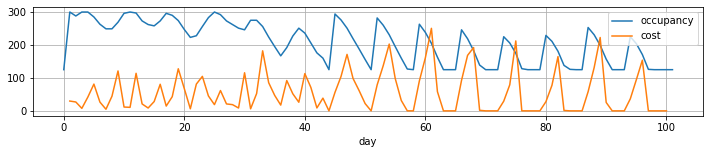

In [13]:
plt.figure(figsize=(12, 2))
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.legend(); plt.grid(); plt.show()

In [14]:
print(max(accounting_cost_per_day), accounting_cost_per_day)

250.48410034179688 1       29.788443
2       26.920185
3        7.577722
4       41.944504
5       81.210869
          ...    
96     153.777359
97       0.030912
98       0.000000
99       0.000000
100      0.000000
Length: 100, dtype: float64


### Family preferred days

In [15]:
day_rank_count = np.zeros((10, N_days+1), dtype='int32')

In [16]:
for r in range(10):
    family_pref_r = family_pref[:, r]
    for day, size in zip(family_pref_r, n_people):
        day_rank_count[r, day] += size

In [17]:
day_rank_count

array([[   0, 1576,  202, ...,   56,   57,   43],
       [   0, 1478,  131, ...,   53,   64,   41],
       [   0, 1337,  168, ...,   48,   39,   62],
       ...,
       [   0, 1053,  201, ...,   70,   34,   71],
       [   0,  830,  217, ...,   38,   41,   73],
       [   0,  845,  158, ...,   54,   69,   56]])

In [18]:
day_rank_acc_count = np.zeros((10, N_days+1), dtype='int32')
for rank_acc in range(10):
    day_rank_acc_count[rank_acc] = day_rank_count[rank_acc]
    for r in range(1, rank_acc + 1):
        day_rank_acc_count[rank_acc] += day_rank_count[r]

In [19]:
day_rank_acc_count

array([[    0,  1576,   202, ...,    56,    57,    43],
       [    0,  2956,   262, ...,   106,   128,    82],
       [    0,  4152,   467, ...,   149,   142,   165],
       ...,
       [    0,  9370,  1430, ...,   491,   398,   496],
       [    0,  9977,  1663, ...,   497,   446,   571],
       [    0, 10837,  1762, ...,   567,   543,   610]])

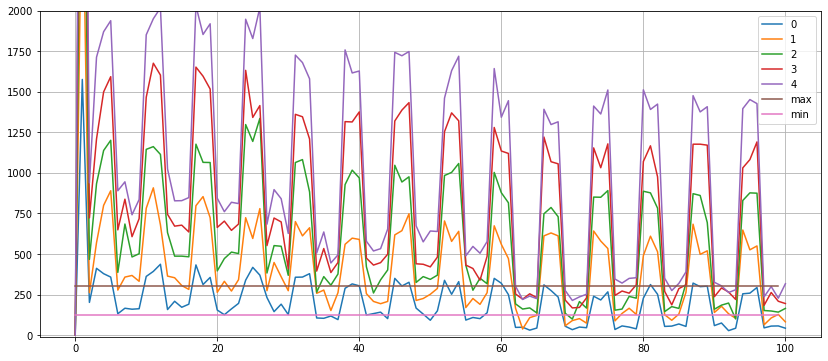

In [20]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.ylim(-10, 2000)
plt.grid(); plt.legend(); plt.show()

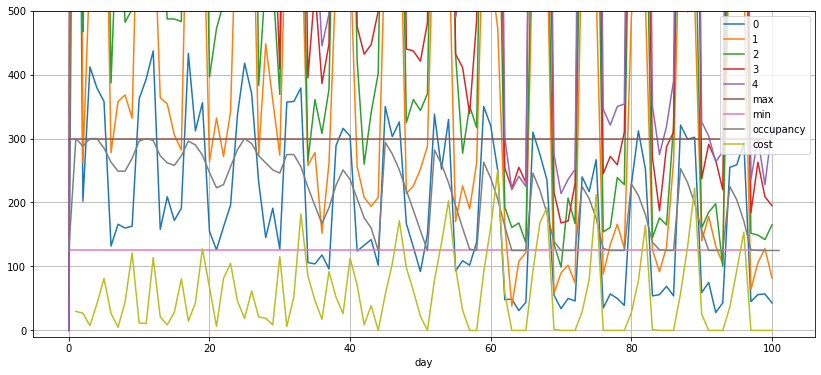

In [21]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

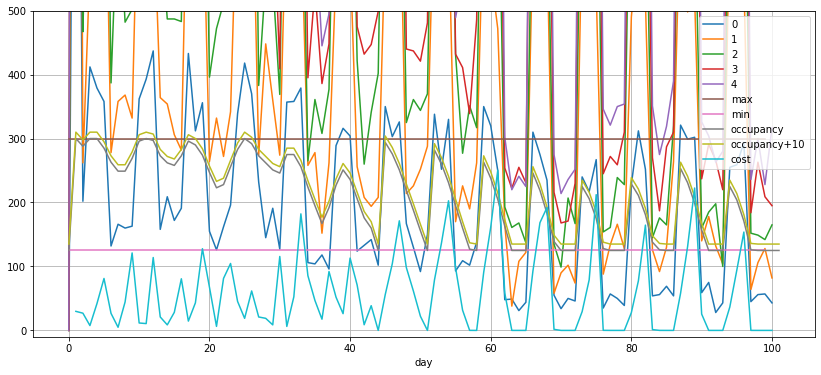

In [22]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(occupancy+occupancy_diff_low, label='occupancy+10')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

## Setup

In [23]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
    if day == 1:
        search_occupancy[day] = [N_max_people]
    elif day == N_days:
        search_occupancy[day] = [N_min_people]
    elif occupancy[day] == N_min_people:
        search_occupancy[day] = range(N_min_people, occupancy[day] + occupancy_diff_low + 1)
    else:
        search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people),
                                      min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [24]:
for i, x in search_occupancy.items():
    print(i, x)

1 [300]
2 range(125, 301)
3 range(125, 301)
4 range(125, 301)
5 range(125, 301)
6 range(125, 301)
7 range(125, 301)
8 range(125, 301)
9 range(125, 301)
10 range(125, 301)
11 range(125, 301)
12 range(125, 301)
13 range(125, 301)
14 range(125, 301)
15 range(125, 301)
16 range(125, 301)
17 range(125, 301)
18 range(125, 301)
19 range(125, 301)
20 range(125, 301)
21 range(125, 301)
22 range(125, 301)
23 range(125, 301)
24 range(125, 301)
25 range(125, 301)
26 range(125, 301)
27 range(125, 301)
28 range(125, 301)
29 range(125, 301)
30 range(125, 301)
31 range(125, 301)
32 range(125, 301)
33 range(125, 301)
34 range(125, 301)
35 range(125, 301)
36 range(125, 301)
37 range(125, 301)
38 range(125, 301)
39 range(125, 301)
40 range(125, 301)
41 range(125, 301)
42 range(125, 301)
43 range(125, 301)
44 range(125, 136)
45 range(125, 301)
46 range(125, 301)
47 range(125, 301)
48 range(125, 301)
49 range(125, 301)
50 range(125, 301)
51 range(125, 136)
52 range(125, 301)
53 range(125, 301)
54 range(125

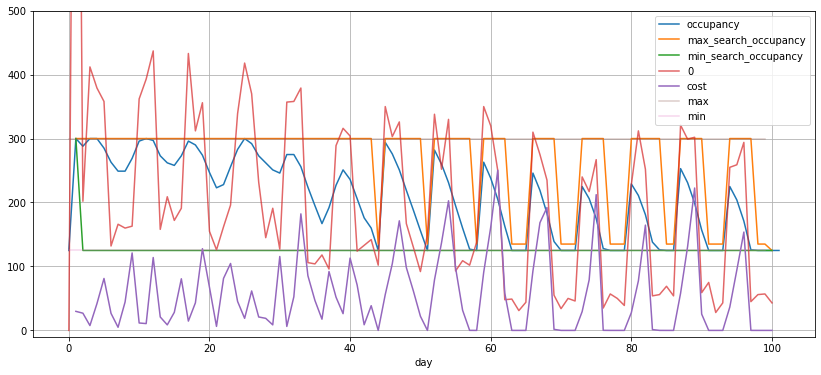

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(occupancy, label='occupancy')
plt.plot(pd.Series({d: max(v) for d, v in search_occupancy.items()}), label='max_search_occupancy')
plt.plot(pd.Series({d: min(v) for d, v in search_occupancy.items()}), label='min_search_occupancy')
for i in range(1):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i), alpha=0.7)
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.plot([N_max_people]*N_days, label='max', alpha=0.3)
plt.plot([N_min_people]*N_days, label='min', alpha=0.3)
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

In [26]:
# occupancy pairs [o, o_next] limited by accounting cost
viable_nd_ndp1 = nd_ndp1_to_account_penality <= max_accounting_cost_per_day

In [27]:
viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum()

15130

(125, 300)

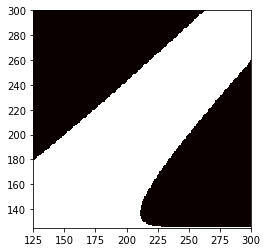

In [28]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [29]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 7


In [30]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[  0,  50,  86, ..., 236, 272, 372],
       [  0,  50,  86, ..., 236, 272, 372],
       [  0,  50,  77, ..., 227, 254, 354],
       ...,
       [  0,  50, 104, ..., 254, 308, 408],
       [  0,  50,  95, ..., 245, 290, 390],
       [  0,  50,  86, ..., 236, 272, 372]], dtype=int64)

## DOCplex model

In [31]:
from docplex.mp.model import Model

In [32]:
solver = Model('')

In [33]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 20
Num treads: threads:int(20)
Set time limit: None


In [34]:
solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0

## Variables

In [35]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [36]:
len(assignment_matrix)

35000

In [37]:
possible_family_sizes = np.unique(n_people)

In [38]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    print('using unpreferred day counts')
    ub = int(N_max_people / possible_family_sizes.min())
    unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')
    print(len(unpreferred_day_counts))    

In [39]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_keys_list = []
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                if viable_nd_ndp1[o, o_next]:
                    occupancy_keys_list.append((day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            if viable_nd_ndp1[o, o]:
                occupancy_keys_list.append((day, o))
occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')

In [40]:
search_occupancy[N_days]

[125]

In [41]:
len(occupancy_matrix)

1074836

## Constraints

### constraint 1: each family only take one day (choice)

In [42]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_([
    solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
    for family in families
])

### constraint: choices limit

In [43]:
if min_choice_0_families > 0:
    solver.add_constraint_(
        solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
    )

### occupancy counts

In [44]:
# constraint 2: each day can only have 125-300 people

In [45]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

7

In [46]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [47]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [48]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [49]:
if not occupancy_count_as_variables:
    for day in days:
        solver.add_range(min(search_occupancy[day]), 
                         occupancy_counts[day], 
                         max(search_occupancy[day]))

### constraint 3: unpreferred day family count conservation for each family size

In [50]:
# constraint 3: unpreferred day family count conservation for each family size

In [51]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [52]:
if N_choices >= N_choices_ori:
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, N_choices - 1]
                    for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ])

### Occupancy boolean matrix normalization

In [53]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o, o_next] 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o] 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]
        ])
    solver.add_constraint_(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [54]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o, o_next] * o 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o] * o 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]            
        ])
    solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)

In [55]:
# next day occupancy consistency
solver.add_constraints_([
    occupancy_counts[day + 1] == solver.sum([
        occupancy_matrix[day, o, o_next] * o_next 
        for o in search_occupancy[day]
        for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next]            
    ])
    for day in days if day < N_days
])

# redudant constraints
if redundant_occupancy_constraints:
    for day in days:
        if day + 1 < N_days:
            solver.add_constraints_([
                solver.sum([
                    occupancy_matrix[day, o_other, o] 
                    for o_other in search_occupancy[day] if viable_nd_ndp1[o_other, o]
                ]) == solver.sum([
                    occupancy_matrix[day + 1, o, o_other]
                    for o_other in search_occupancy[day + 2] if viable_nd_ndp1[o, o_other]
                ])
                for o in search_occupancy[day + 1]
            ])
    solver.add_constraints_([
        solver.sum([
            occupancy_matrix[N_days - 1, o_other, o] 
            for o_other in search_occupancy[N_days - 1] if viable_nd_ndp1[o_other, o]
        ]) == occupancy_matrix[N_days, o] if viable_nd_ndp1[o, o] else 0
        for o in search_occupancy[N_days]
    ])

### Preference cost

In [56]:
family_pref_cost = solver.sum([
    assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
    for family in families for c in range(1, N_choices)
])

In [57]:
if target_pref_cost > 0:
    if target_pref_cost_error > 0:
        print('Limit preference cost in range')
        solver.add_range(
            target_pref_cost - target_pref_cost_error,
            family_pref_cost,
            target_pref_cost + target_pref_cost_error
        )
    else:
        print('Limit preference cost exactly')
        solver.add_constraint_(family_pref_cost == target_pref_cost)
elif target_pref_cost_lower > 0:
    print('Lower bound preference cost')
    solver.add_constraint_(family_pref_cost >= target_pref_cost_lower)

Lower bound preference cost


### Accounting cost

In [58]:
accounting_cost = (
    solver.sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next] and o > N_min_people
    ]) +
    solver.sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
        if viable_nd_ndp1[o, o] and o > N_min_people  
    ])
)

In [59]:
if target_accounting_cost > 0:
    if target_accounting_cost_error > 0:
        print('Range limit accounting cost')
        solver.add_range(
            target_accounting_cost - target_accounting_cost_error,
            accounting_cost,
            target_accounting_cost - target_accounting_cost_error
        )
elif target_accounting_cost_lower > 0:
    print('Lower bound accounting cost')
    solver.add_constraint_(accounting_cost >= target_accounting_cost_lower)

Lower bound accounting cost


In [60]:
#accounting_cost.GetCoeffs()[occupancy_matrix[100, 128]]

## Objective

In [61]:
# Objective - Preference cost only as approximation
solver.minimize(family_pref_cost + accounting_cost)  # family_pref_cost + 

## Hint

In [62]:
if use_hint:
    print('Using hint!')

    from docplex.mp.solution import SolveSolution
    var_value_map = {}
    
    for family in families:
        for c in range(N_choices):
            var_value_map[assignment_matrix[family, c]] = float(
                assigned_day[family] == family_pref[family, c]
            )
    for day in days:
        if day < N_days:
            for o in search_occupancy[day]:
                for o_next in search_occupancy[day + 1]:
                    if viable_nd_ndp1[o, o_next]:
                        var_value_map[occupancy_matrix[day, o, o_next]] = float(
                            (occupancy[day] == o) and (occupancy[day + 1] == o_next)
                        )
                    else:
                        assert not ((occupancy[day] == o) and (occupancy[day + 1] == o_next)), \
                        'Hint not valid at (%i, %i, %i)'%(day, o, o_next)
    for o in search_occupancy[N_days]:
        if viable_nd_ndp1[o, o]:
            var_value_map[occupancy_matrix[N_days, o]] = float(occupancy[N_days] == o)
        else:
            assert not (occupancy[N_days] == o), \
            'Hint not valid at (%i, %i, %i)'%(N_days, o, o)

    if occupancy_count_as_variables:
        for day in days:
            var_value_map[occupancy_counts[day]] = float(occupancy[day])
    
    init_solution = SolveSolution(solver, var_value_map)
    solver.add_mip_start(init_solution)

Using hint!


## Solve

In [63]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock
from docplex.mp.progress import SolutionRecorder

See http://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.progress.html#docplex.mp.progress.ProgressClock for progress clock parameters meaning

In [64]:
class MyProgressListener(SolutionRecorder):
    def __init__(self, clock=ProgressClock.Gap, absdiff=None, reldiff=None):
        super(MyProgressListener, self).__init__(clock, absdiff, reldiff)
        self.current_objective = initial_score or 999999
        
    def notify_solution(self, sol):
        if self.current_progress_data.current_objective >= self.current_objective:
            return
        print ('Improved solution')
        super(MyProgressListener, self).notify_solution(sol)
        self.current_objective = self.current_progress_data.current_objective
        assigned_day_new_raw = np.ones(N_families, dtype='int32') * -1
        for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
            assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1
        solution = pd.DataFrame(data=families, columns = ['family_id'])
        solution['assigned_day'] = assigned_day_new_raw
        #score = cost_function(preds)
        #print('Score: ' + str(score))        
        solution.to_csv(path_dump_improved, index=False)
        
    def get_solutions(self):
        return self._solutions

In [65]:
# print progress
my_progress_listener = MyProgressListener(clock=ProgressClock.Gap)
solver.add_progress_listener(
#     TextProgressListener(clock=ProgressClock.Gap)
    my_progress_listener
)  
# clock=ProgressClock.Objective, absdiff=10
# ProgressClock.All

In [66]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)
print('Time limit:', solver.get_time_limit())

N of variables (binary, int): 1109836 ( 1109836 , 0 )
N of constraints: 19516
Time limit: 345600.0


In [67]:
%%time
# Solve
sol = solver.solve(log_output=True)

if sol is None:
    sol = my_progress_listener.get_solutions()[-1]

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 20
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               345600
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve time = 0.14 sec. (176.43 ticks)
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69670.7533.
Presolve has eliminated 2203 rows and 180929 columns...
Tried aggregator 2 times.
MIP Presolve eliminated 2203 rows and 180929 columns.
MIP Presolve modified 48203 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 17310 rows, 929006 columns, and 5522048 nonzeros.
Reduced MIP has 928908 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 7.52 sec. (11084.30 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 17310 rows, 929006 columns, and 5522048 nonzeros.
Reduced MIP has 928908 b

     77    65    68854.4448   628    69670.7533    68445.0000   594248    1.76%
     78    62    68709.9924   685    69670.7533    68445.0000   584786    1.76%
Elapsed time = 8240.98 sec. (13768463.70 ticks, tree = 9.54 MB, solutions = 1)
     79    54    68666.8065   569    69670.7533    68445.0000   556714    1.76%
     80    66    68624.7985   661    69670.7533    68445.0000   597285    1.76%
     83    73    68651.1334   631    69670.7533    68445.0000   621887    1.76%
     85    74    68644.2510   686    69670.7533    68445.0000   624572    1.76%
     87    71    68615.1214   705    69670.7533    68445.0000   614536    1.76%
     88    67    68646.6668   656    69670.7533    68445.0000   601412    1.76%
     89    70    68707.7004   693    69670.7533    68445.0000   611854    1.76%
     90    57    68662.7413   629    69670.7533    68445.0000   568413    1.76%
     91    75    68644.2583   686    69670.7533    68445.0000   624633    1.76%
     93    60    68851.5092   604    6967

   1044   791    69058.4022   299    69670.7533    68445.0000   969337    1.76%
   1072   759    69610.9499   170    69670.7533    68445.0000   903738    1.76%
   1103   782    69631.7021   138    69670.7533    68445.0000   904241    1.76%
   1126   804    69067.8820   283    69670.7533    68445.0000   971160    1.76%
   1141   757    69037.5802   263    69670.7533    68445.0000   948149    1.76%
   1156   657    68925.7750   278    69670.7533    68445.0000   924118    1.76%
   1161   813    69445.3790   225    69670.7533    68445.0000   974061    1.76%
   1181   828    69452.9424   204    69670.7533    68445.0000   974328    1.76%
   1200   767    69410.0936   242    69670.7533    68445.0000   951500    1.76%
Elapsed time = 9386.08 sec. (14153595.53 ticks, tree = 264.26 MB, solutions = 1)
   1224   857    69458.2913   180    69670.7533    68445.0000   974904    1.76%
   1246   874    69471.4945   189    69670.7533    68445.0000   975309    1.76%
   1252   875    69471.0941   181    69

   2353  2053    68975.5388   326    69670.7533    68445.0000  1489653    1.76%
   2355  2106    69652.7041   241    69670.7533    68445.0000  1512270    1.76%
   2360  1802    68987.2749   297    69670.7533    68445.0000  1383550    1.76%
   2365  2109        cutoff          69670.7533    68445.0000  1515730    1.76%
   2370  2035    68703.9412   664    69670.7533    68445.0000  1475561    1.76%
Elapsed time = 10553.83 sec. (14552548.36 ticks, tree = 822.52 MB, solutions = 1)
   2377  1822    68655.4306   795    69670.7533    68445.0000  1434724    1.76%
   2385  2119    69330.1961   228    69670.7533    68445.0000  1518739    1.76%
   2389  2119    68989.1111   309    69670.7533    68445.0000  1520669    1.76%
   2395  2123    69338.5228   233    69670.7533    68445.0000  1520753    1.76%
   2398  2124    69646.1325   224    69670.7533    68445.0000  1522115    1.76%
   2407  2139    68997.5266   301    69670.7533    68445.0000  1534669    1.76%
   2410  2141    68997.8905   315    6

   3129  2745    69293.9579   261    69670.7533    68445.0000  1981784    1.76%
Elapsed time = 11801.12 sec. (14972952.37 ticks, tree = 1174.09 MB, solutions = 1)
   3133  2799    69062.6578   351    69670.7533    68445.0000  2019480    1.76%
   3136  2748    69294.1747   257    69670.7533    68445.0000  1983416    1.76%
   3138  2750    69575.9024   250    69670.7533    68445.0000  1984915    1.76%
   3142  2800    69286.9003   336    69670.7533    68445.0000  2021417    1.76%
   3146  2754    69297.1162   267    69670.7533    68445.0000  1986589    1.76%
   3149  2782    68951.2612   595    69670.7533    68445.0000  2007752    1.76%
   3152  2785    68736.1304   694    69670.7533    68445.0000  2010365    1.76%
   3157  2805    69066.7466   334    69670.7533    68445.0000  2023874    1.76%
   3163  2802    68740.5134   733    69670.7533    68445.0000  2025810    1.76%
   3169  2854    69306.1711   259    69670.7533    68445.0000  2042843    1.76%
Elapsed time = 11955.48 sec. (1502320

   3670  3374    69153.1927   358    69670.7533    68445.0000  2479706    1.76%
   3674  3375    69155.8589   435    69670.7533    68445.0000  2480071    1.76%
   3677  3389    68783.4572   808    69670.7533    68445.0000  2484385    1.76%
   3678  3390    68783.9098   749    69670.7533    68445.0000  2484613    1.76%
   3680  3391    68785.3009   798    69670.7533    68445.0000  2484911    1.76%
   3682  3406    68815.7797   609    69670.7533    68445.0000  2526807    1.76%
   3690  3380    69167.3827   350    69670.7533    68445.0000  2480478    1.76%
   3696  3385    69171.9159   346    69670.7533    68445.0000  2480823    1.76%
Elapsed time = 13223.11 sec. (15465078.71 ticks, tree = 1490.30 MB, solutions = 1)
   3701  3399    68769.4027   827    69670.7533    68445.0000  2515602    1.76%
   3705  3395    68786.7695   786    69670.7533    68445.0000  2485920    1.76%
   3708  3397    68787.0879   794    69670.7533    68445.0000  2486252    1.76%
   3710  3418    68817.4905   684    

   4562  3932    69598.4554   189    69670.7533    68445.0000  2877356    1.76%
   4575  3831    69133.7988   363    69670.7533    68445.0000  2835813    1.76%
   4601  3958    69639.4882   178    69670.7533    68445.0000  2878198    1.76%
   4625  3843    69143.7479   366    69670.7533    68445.0000  2836513    1.76%
Elapsed time = 14375.52 sec. (15859862.24 ticks, tree = 1717.35 MB, solutions = 1)
   4646  3937    69103.8481   425    69670.7533    68445.0000  2911404    1.76%
   4651  3853    69184.3016   291    69670.7533    68445.0000  2837496    1.76%
   4653  3276    68771.3834   711    69670.7533    68445.0000  2409186    1.76%
   4657  3428    68819.1485   602    69670.7533    68445.0000  2556037    1.76%
   4662  3732    69215.9107   456    69670.7533    68445.0000  2807282    1.76%
   4667  3963    69145.6668   330    69670.7533    68445.0000  2923701    1.76%
   4679  3863    69568.2830   247    69670.7533    68445.0000  2843892    1.76%
   4696  3970    69146.8517   312    

   5395  4715    68823.2215   615    69670.7533    68445.0000  3247905    1.76%
   5397  4671    69232.8475   232    69670.7533    68445.0000  3217844    1.76%
Elapsed time = 15409.47 sec. (16269161.91 ticks, tree = 2184.49 MB, solutions = 1)
Nodefile size = 101.32 MB (38.50 MB after compression)
   5401  4802    69243.8501   231    69670.7533    68445.0000  3313447    1.76%
   5411  4721    69135.4172   407    69670.7533    68445.0000  3232330    1.76%
   5421  4666    68992.8090   341    69670.7533    68445.0000  3207765    1.76%
   5425  4735    69002.0879   496    69670.7533    68445.0000  3270128    1.76%
   5437  4727    68809.5026   640    69670.7533    68445.0000  3260244    1.76%
   5445  4737    69166.5091   343    69670.7533    68445.0000  3233696    1.76%
   5452  4708    68744.9247   897    69670.7533    68445.0000  3237684    1.76%
   5458  4835    69007.3622   451    69670.7533    68445.0000  3324844    1.76%
   5465  4810    69294.7580   239    69670.7533    68445.0000 

   5798     0    68703.7885  1299    69670.7533      Cuts: 67  4657371    1.39%
   5798     0    68705.6832  1299    69670.7533      Cuts: 98  4659181    1.39%
   5798     0    68708.3968  1299    69670.7533      Cuts: 58  4661154    1.38%
   5798     0    68710.0307  1299    69670.7533      Cuts: 65  4662590    1.38%
   5798     2    68710.0307  1051    69670.7533    68710.0407  4662590    1.38%
   5801     4    68795.5050   924    69670.7533    68710.0655  4665783    1.38%
   5802     4    68795.6869   913    69670.7533    68710.0655  4666467    1.38%
   5803     5    68795.8823   888    69670.7533    68710.0655  4666945    1.38%
   5804     4        cutoff          69670.7533    68710.0655  4667575    1.38%
   5805     6    68796.0736   905    69670.7533    68710.0655  4667236    1.38%
   5806     4    68710.0692  1047    69670.7533    68710.0655  4662639    1.38%
Elapsed time = 30217.75 sec. (41950217.09 ticks, tree = 0.02 MB, solutions = 1)
   5807     6    68796.0913   891    696

   6033   157    69140.2511   546    69670.7533    68711.1755  4870644    1.38%
   6035    76    69275.1486   489    69670.7533    68711.1755  4773562    1.38%
   6036   165    68871.9875   771    69670.7533    68711.1755  4881482    1.38%
   6038   113    68850.3611   673    69670.7533    68711.1755  4835321    1.38%
   6044   166    68872.7247   768    69670.7533    68711.1755  4881843    1.38%
   6048   175    68979.1629   558    69670.7533    68711.1755  4891975    1.38%
   6055   185    69080.5893   603    69670.7533    68711.1755  4904641    1.38%
Elapsed time = 32085.73 sec. (42719403.79 ticks, tree = 41.68 MB, solutions = 1)
   6061   148    69148.3647   516    69670.7533    68711.1755  4867404    1.38%
   6068   186    69080.9334   578    69670.7533    68711.1755  4905038    1.38%
   6070   136    69575.6783   357    69670.7533    68711.1755  4859178    1.38%
   6076   168    68873.0348   750    69670.7533    68711.1755  4883092    1.38%
   6081   200    68869.7635   721    69

   6446   470    69231.5685   377    69670.7533    68711.1755  5213267    1.38%
   6450   465    69051.3357   682    69670.7533    68711.1755  5221932    1.38%
   6451   473    69241.0741   397    69670.7533    68711.1755  5213857    1.38%
Elapsed time = 33410.84 sec. (43170835.74 ticks, tree = 116.09 MB, solutions = 1)
   6456   424    69164.6189   772    69670.7533    68711.1755  5191687    1.38%
   6459   466    69054.1229   682    69670.7533    68711.1755  5222581    1.38%
   6464   510    68743.5107   867    69670.7533    68711.1755  5262008    1.38%
   6467   496    68978.3828   401    69670.7533    68711.1755  5241274    1.38%
   6471   481    69141.0333   462    69670.7533    68711.1755  5231727    1.38%
   6477   500    68975.9144   456    69670.7533    68711.1755  5241755    1.38%
   6479   507    68804.4429   883    69670.7533    68711.1755  5256021    1.38%
   6481   534    69228.5263   355    69670.7533    68711.1755  5272324    1.38%
   6485   501    69204.3404   685    6

   7180   921    69595.8146   311    69670.7533    68711.1755  5576697    1.38%
   7185   924    68965.3777   497    69670.7533    68711.1755  5576920    1.38%
   7188   801    69210.4499   397    69670.7533    68711.1755  5489792    1.38%
   7195   632    68743.5219   858    69670.7533    68711.1755  5365073    1.38%
   7202   905    69145.2084   437    69670.7533    68711.1755  5544410    1.38%
   7205   803    69216.0312   390    69670.7533    68711.1755  5492305    1.38%
   7209   803        cutoff          69670.7533    68711.1755  5493803    1.38%
   7221   958    69142.9134   559    69670.7533    68711.1755  5613904    1.38%
   7228   777    69237.4674   627    69670.7533    68711.1755  5471195    1.38%
   7231   806    69230.8515   389    69670.7533    68711.1755  5495180    1.38%
Elapsed time = 34878.22 sec. (43628284.67 ticks, tree = 235.60 MB, solutions = 1)
   7239   909    69150.7054   436    69670.7533    68711.1755  5546360    1.38%
   7243   911    69150.8224   437    6

  10465  3609    69614.9444   325    69670.7533    68711.1755  7047067    1.38%
  10510  3652    69110.7841   426    69670.7533    68711.1755  7085336    1.38%
  10556  3626    69622.4045   323    69670.7533    68711.1755  7052843    1.38%
  10600  3635    69621.9512   324    69670.7533    68711.1755  7055617    1.38%
  10652  3659    69111.2416   409    69670.7533    68711.1755  7088054    1.38%
  10676  3630    69313.1341   369    69670.7533    68711.1755  7069432    1.38%
Elapsed time = 38465.59 sec. (44831898.72 ticks, tree = 1542.05 MB, solutions = 1)
  10704  3702    69409.7828   395    69670.7533    68711.1755  7116454    1.38%
  10737  3641    69323.1231   346    69670.7533    68711.1755  7072721    1.38%
  10759  3668        cutoff          69670.7533    68711.1755  7092023    1.38%
  10795  3718    69413.1686   350    69670.7533    68711.1755  7120197    1.38%
  10816  3835    68891.8079   590    69670.7533    68711.1755  7208282    1.38%
  10852  3925    68742.9092   845    

  13810  6612    69110.9334   382    69670.7533    68711.1755  8399283    1.38%
  13843  7120    69275.3650   451    69670.7533    68711.1755  8556020    1.38%
  13909  7114    69063.9686   342    69670.7533    68711.1755  8551735    1.38%
  14023  7219    69099.4233   293    69670.7533    68711.1755  8598854    1.38%
  14060  7224    69115.6958   306    69670.7533    68711.1755  8600128    1.38%
  14084  7133    69281.0571   544    69670.7533    68711.1755  8559848    1.38%
Elapsed time = 42632.39 sec. (46241096.30 ticks, tree = 3237.74 MB, solutions = 1)
Nodefile size = 1169.26 MB (470.81 MB after compression)
  14174  7324    69534.3766   133    69670.7533    68711.1755  8531438    1.38%
  14244  6756    69063.9078   484    69670.7533    68711.1755  8500129    1.38%
  14266  7141    69292.4086   548    69670.7533    68711.1755  8562827    1.38%
  14280  7236    69121.2606   298    69670.7533    68711.1755  8603992    1.38%
  14298  7137    69099.2523   323    69670.7533    68711.175

  17572 10704    69653.6385   297    69670.7533    68711.1755  9952540    1.38%
  17608 10693    69381.3411   388    69670.7533    68711.1755  9965918    1.38%
  17625 10696    69382.4942   399    69670.7533    68711.1755  9967354    1.38%
  17643 10742    68746.9942   778    69670.7533    68711.1755 10021393    1.38%
  17661 10743    68747.4402   776    69670.7533    68711.1755 10022123    1.38%
  17679 10811    69109.5979   473    69670.7533    68711.1755 10095818    1.38%
  17697 10813    69111.0342   371    69670.7533    68711.1755 10096823    1.38%
  17715 10792    68826.4444   611    69670.7533    68711.1755 10088499    1.38%
  17733 10769    68867.8520   486    69670.7533    68711.1755 10054389    1.38%
Elapsed time = 46546.64 sec. (47654233.23 ticks, tree = 5003.34 MB, solutions = 1)
Nodefile size = 2940.30 MB (1179.06 MB after compression)
  17750 10774    68868.8064   476    69670.7533    68711.1755 10055162    1.38%
  17764 10784    68785.3201   547    69670.7533    68711.17

Elapsed time = 50421.97 sec. (48928414.50 ticks, tree = 5786.81 MB, solutions = 1)
Nodefile size = 3713.10 MB (1475.37 MB after compression)
  19649 12512    68891.5582   395    69670.7533    68711.1755 11208964    1.38%
  19674 12552    69320.4086   379    69670.7533    68711.1755 11242593    1.38%
  19703 12625    69108.1553   523    69670.7533    68711.1755 11270124    1.38%
  19732 12441    69466.3234   712    69670.7533    68711.1755 11182641    1.38%
  19783 12580    69401.8112   258    69670.7533    68711.1755 11247763    1.38%
  19825 12590    69402.9038   246    69670.7533    68711.1755 11249804    1.38%
  19866 12603    69414.6966   219    69670.7533    68711.1755 11251379    1.38%
  19911 12704    69348.1702   417    69670.7533    68711.1755 11332981    1.38%
  19947 12955    69438.6746   173    69670.7533    68711.1755 11454250    1.38%
  20004 12987    69451.1787   134    69670.7533    68711.1755 11456028    1.38%
Elapsed time = 50866.48 sec. (49086292.48 ticks, tree = 605

  21027 14232    69301.2861   606    69670.7533    68711.1755 11982034    1.38%
  21033 14235    69304.2076   625    69670.7533    68711.1755 11983332    1.38%
  21039 14241    68892.6346   415    69670.7533    68711.1755 11985347    1.38%
Elapsed time = 55707.94 sec. (52202069.23 ticks, tree = 6653.65 MB, solutions = 1)
Nodefile size = 4581.68 MB (1806.40 MB after compression)
  21044 14243    68894.1673   484    69670.7533    68711.1755 11986957    1.38%
  21045 14244    68894.6561   404    69670.7533    68711.1755 11987854    1.38%
  21048 14247    68896.5505   537    69670.7533    68711.1755 11989147    1.38%
  21054 14252    68897.3098   554    69670.7533    68711.1755 11989929    1.38%
  21059 14257    68898.0735   515    69670.7533    68711.1755 11990862    1.38%
  21062 14260    68899.7813   499    69670.7533    68711.1755 11991757    1.38%
  21068 14229    69576.9167   209    69670.7533    68711.1755 11979515    1.38%
  21124 14287    69621.0256   198    69670.7533    68711.17

  22557 15049    69614.7378   322    69670.7533    68711.1755 12336406    1.38%
  22590 15070    69601.3129   276    69670.7533    68711.1755 12338621    1.38%
  22623 14940    69041.8644   502    69670.7533    68711.1755 12264042    1.38%
  22645 15093    68856.8985   406    69670.7533    68711.1755 12380125    1.38%
  22667 15423    69044.4708   515    69670.7533    68711.1755 12515983    1.38%
  22696 15278    68868.7886   604    69670.7533    68711.1755 12478772    1.38%
Elapsed time = 59020.08 sec. (53735704.13 ticks, tree = 7151.24 MB, solutions = 1)
Nodefile size = 5082.59 MB (1997.88 MB after compression)
  22726 15097    68848.4192   419    69670.7533    68711.1755 12382474    1.38%
  22748 15101    68851.4708   406    69670.7533    68711.1755 12383367    1.38%
  22774 15351    69645.4943   292    69670.7533    68711.1755 12473948    1.38%
  22801 15488    69065.5627   521    69670.7533    68711.1755 12543912    1.38%
  22847 15614        cutoff          69670.7533    68711.17

  25206 17428    68865.1780   444    69670.7533    68712.0613 13438871    1.38%
  25254 17352    69210.7527   212    69670.7533    68712.0613 13395520    1.38%
  25310 17107    68902.7966   315    69670.7533    68712.0613 13310292    1.38%
  25356 17502    68815.4025   494    69670.7533    68712.0613 13455614    1.38%
  25396 17374    69216.4052   222    69670.7533    68712.0613 13400114    1.38%
  25433 17591    68867.2708   668    69670.7533    68712.0613 13521482    1.38%
  25466 17861    68866.5858   379    69670.7533    68712.0613 13641832    1.38%
  25495 17153    69199.4172   400    69670.7533    68712.0613 13348444    1.38%
  25525 17121    68907.3998   331    69670.7533    68712.0613 13316284    1.38%
Elapsed time = 62774.77 sec. (55166456.51 ticks, tree = 8025.35 MB, solutions = 1)
Nodefile size = 5933.66 MB (2319.72 MB after compression)
  25551 17550    69010.4924   375    69670.7533    68712.0613 13482043    1.38%
  25584 17803    69372.6660   283    69670.7533    68712.06

Elapsed time = 66855.97 sec. (56420551.33 ticks, tree = 9820.40 MB, solutions = 1)
Nodefile size = 7734.98 MB (2991.33 MB after compression)
  28801 21038    69113.9715   574    69670.7533    68712.0613 15014245    1.38%
  28822 20841    69115.5536   468    69670.7533    68712.0613 14932710    1.38%
  28863 20844    69116.1687   428    69670.7533    68712.0613 14933631    1.38%
  28898 21176    68837.0099   640    69670.7533    68712.0613 15094275    1.38%
  28933 20902    69086.7006   261    69670.7533    68712.0613 14961387    1.38%
  28967 21160    69521.9745   314    69670.7533    68712.0613 15053967    1.38%
  29006 21169    69524.6577   303    69670.7533    68712.0613 15055658    1.38%
  29035 21377    68955.4385   373    69670.7533    68712.0613 15205273    1.38%
  29065 21055    69128.2833   568    69670.7533    68712.0613 15020199    1.38%
  29100 20772    68738.0921   821    69670.7533    68712.0613 14919146    1.38%
Elapsed time = 67277.37 sec. (56577339.71 ticks, tree = 976

  31388 23526    69132.5013   508    69670.7533    68712.0613 16302653    1.38%
  31402 23712    69049.0999   600    69670.7533    68712.0613 16431710    1.38%
  31420 23604    68969.9781   727    69670.7533    68712.0613 16393187    1.38%
Elapsed time = 71176.08 sec. (57841429.97 ticks, tree = 11104.28 MB, solutions = 1)
Nodefile size = 9033.08 MB (3474.95 MB after compression)
  31440 23792    69318.3990   354    69670.7533    68712.0613 16469237    1.38%
  31467 23530    69134.0847   483    69670.7533    68712.0613 16304542    1.38%
  31495 23802    69320.9853   341    69670.7533    68712.0613 16472149    1.38%
  31524 23729    69054.1970   595    69670.7533    68712.0613 16435279    1.38%
  31549 23734    69054.7303   541    69670.7533    68712.0613 16435968    1.38%
  31580 23575    69160.7943   371    69670.7533    68712.0613 16332874    1.38%
  31613 23583    69164.4893   389    69670.7533    68712.0613 16334229    1.38%
  31646 23337    68914.3065   482    69670.7533    68712.0

  34181 26028    68767.6101   795    69670.7533    68712.0613 17392765    1.38%
  34201 26257    68800.5023   612    69670.7533    68712.0613 17480415    1.38%
  34219 25833    69146.7400   630    69670.7533    68712.0613 17319853    1.38%
  34246 26074    68772.7955   679    69670.7533    68712.0613 17409919    1.38%
  34267 26388    69354.6477   396    69670.7533    68712.0613 17564556    1.38%
  34288 26393    69350.4350   354    69670.7533    68712.0613 17565678    1.38%
Elapsed time = 75480.16 sec. (59269496.41 ticks, tree = 12426.34 MB, solutions = 1)
Nodefile size = 10349.83 MB (3963.91 MB after compression)
  34306 26265    68801.4522   637    69670.7533    68712.0613 17483533    1.38%
  34323 26068    69070.1731   512    69670.7533    68712.0613 17376556    1.38%
  34344 26342    69159.7885   445    69670.7533    68712.0613 17544616    1.38%
  34365 26287    68773.9488   771    69670.7533    68712.0613 17505025    1.38%
  34387 26345    69146.7577   462    69670.7533    68712.

  36272 28445    69052.5771   422    69670.7533    68712.0613 18705285    1.38%
  36293 28029    68753.5140   877    69670.7533    68712.0613 18516664    1.38%
  36315 28032    68753.8038   884    69670.7533    68712.0613 18517302    1.38%
  36340 28546    68950.3264   419    69670.7533    68712.0613 18751077    1.38%
  36370 28076    69290.0408   482    69670.7533    68712.0613 18563582    1.38%
  36400 27890    69233.9847   525    69670.7533    68712.0613 18442672    1.38%
  36430 28437    69605.7492   211    69670.7533    68712.0613 18688056    1.38%
  36464 28506    68758.5899   856    69670.7533    68712.0613 18741166    1.38%
  36507 28457    69616.3689   208    69670.7533    68712.0613 18693723    1.38%
Elapsed time = 79764.22 sec. (60699810.63 ticks, tree = 13391.73 MB, solutions = 1)
Nodefile size = 11288.65 MB (4305.08 MB after compression)
  36538 28500    68813.8380   575    69670.7533    68712.0613 18726369    1.38%
  36564 28675    69236.6692   500    69670.7533    68712.

Elapsed time = 83735.25 sec. (61967779.23 ticks, tree = 14262.90 MB, solutions = 1)
Nodefile size = 12175.28 MB (4628.96 MB after compression)
  38555 30360    68822.5695   628    69670.7533    68712.0613 19805562    1.38%
  38600 30282    69485.6512   347    69670.7533    68712.0613 19731842    1.38%
  38640 30292    69490.2816   336    69670.7533    68712.0613 19733378    1.38%
  38676 30355    69249.9169   521    69670.7533    68712.0613 19788658    1.38%
  38708 30462    69536.7091   279    69670.7533    68712.0613 19861863    1.38%
  38743 30470    69538.3082   264    69670.7533    68712.0613 19863827    1.38%
  38784 30348    69148.2937   569    69670.7533    68712.0613 19760245    1.38%
  38831 30252    68804.7022   655    69670.7533    68712.0613 19706037    1.38%
  38885 30161    68938.5112   650    69670.7533    68712.0613 19668759    1.38%
  38932 30588    69046.3960   656    69670.7533    68712.0613 19951784    1.38%
Elapsed time = 84380.39 sec. (62123150.52 ticks, tree = 1

  41370 32747    68763.9807   881    69670.7533    68712.0613 20955139    1.38%
  41412 32820    68756.1597   838    69670.7533    68712.0613 20997977    1.38%
  41433 33041    69318.2540   424    69670.7533    68712.0613 21102702    1.38%
Elapsed time = 88015.80 sec. (63376240.74 ticks, tree = 15533.41 MB, solutions = 1)
Nodefile size = 13441.28 MB (5092.83 MB after compression)
  41454 32495    68933.3457   452    69670.7533    68712.0613 20858639    1.38%
  41483 32920    69243.7937   514    69670.7533    68712.0613 21047984    1.38%
  41505 32613    68738.1706   843    69670.7533    68712.0613 20901709    1.38%
  41539 32923    69256.8870   507    69670.7533    68712.0613 21049929    1.38%
  41565 33393    68828.2717   598    69670.7533    68712.0613 21335862    1.38%
  41581 33294    69137.8120   549    69670.7533    68712.0613 21282991    1.38%
  41615 33386    68940.3361   392    69670.7533    68712.0613 21304059    1.38%
  41638 32984    69366.6977   369    69670.7533    68712.

  43501 34948    69119.6935   544    69670.7533    68712.0613 22360160    1.38%
  43542 35242    69383.3943   423    69670.7533    68712.0613 22466962    1.38%
  43563 34953    69121.2084   583    69670.7533    68712.0613 22361800    1.38%
  43588 35302    69144.6922   512    69670.7533    68712.0613 22533535    1.38%
  43611 34718    69118.1726   561    69670.7533    68712.0613 22261108    1.38%
  43630 34962    69123.7568   588    69670.7533    68712.0613 22364262    1.38%
Elapsed time = 92372.80 sec. (64818331.42 ticks, tree = 16428.38 MB, solutions = 1)
Nodefile size = 14327.91 MB (5422.00 MB after compression)
  43652 35257    69377.6009   412    69670.7533    68712.0613 22473366    1.38%
  43669 35566    69120.9364   566    69670.7533    68712.0613 22725210    1.38%
  43683 35276    68812.5412   709    69670.7533    68712.0613 22510356    1.38%
  43700 35039    69256.9549   590    69670.7533    68712.0613 22404429    1.38%
  43720 34845    68766.6848   817    69670.7533    68712.

  45554 36847    69349.7486   404    69670.7533    68712.0613 23406590    1.38%
  45590 37117    69228.6596   534    69670.7533    68712.0613 23797089    1.38%
  45619 37085    69086.7156   600    69670.7533    68712.0613 23532261    1.38%
  45638 37123    69233.3745   550    69670.7533    68712.0613 23799112    1.38%
  45667 37090    69088.4232   613    69670.7533    68712.0613 23533847    1.38%
  45687 37029    68797.2382   701    69670.7533    68712.0613 23506162    1.38%
  45713 37097    69090.4748   591    69670.7533    68712.0613 23535404    1.38%
  45732 37321    69184.5709   445    69670.7533    68712.0613 23973287    1.38%
  45756 37032    68798.7777   713    69670.7533    68712.0613 23508124    1.38%
Elapsed time = 96718.28 sec. (66260561.53 ticks, tree = 17387.68 MB, solutions = 1)
Nodefile size = 15292.99 MB (5774.63 MB after compression)
  45776 37746    68799.0740   687    69670.7533    68712.0613 24273289    1.38%
  45797 37391    68792.8766   737    69670.7533    68712.

Elapsed time = 100695.08 sec. (67535755.41 ticks, tree = 18604.27 MB, solutions = 1)
Nodefile size = 16511.25 MB (6217.92 MB after compression)
  47893 39794    68811.9679   673    69670.7533    68712.0613 25445374    1.38%
  47925 39269    69183.2552   562    69670.7533    68712.0613 25140394    1.38%
  47952 38979    69076.6084   387    69670.7533    68712.0613 25001330    1.38%
  47974 39662    69558.6170   379    69670.7533    68712.0613 25397610    1.38%
  47999 39108    69224.1558   643    69670.7533    68712.0613 25079368    1.38%
  48027 39109    69228.2229   631    69670.7533    68712.0613 25081218    1.38%
  48042 39144    68813.3233   635    69670.7533    68712.0613 25113232    1.38%
  48057 39284    69185.8547   530    69670.7533    68712.0613 25145383    1.38%
  48073 39286    69186.1394   472    69670.7533    68712.0613 25146212    1.38%
  48102 39669    68921.5190   510    69670.7533    68712.0613 25402619    1.38%
Elapsed time = 101147.72 sec. (67697365.40 ticks, tree =

  50036 41257    68791.9821   777    69670.7533    68712.0613 26478653    1.38%
  50052 40917    69115.8488   592    69670.7533    68712.0613 26246281    1.38%
  50071 41105    69165.8959   588    69670.7533    68712.0613 26401207    1.38%
Elapsed time = 105114.73 sec. (68979500.07 ticks, tree = 19291.84 MB, solutions = 1)
Nodefile size = 17186.81 MB (6458.76 MB after compression)
  50086 40964    68847.4923   617    69670.7533    68712.0613 26318422    1.38%
  50102 41517    69240.5638   506    69670.7533    68712.0613 26659243    1.38%
  50116 41115    69167.5836   526    69670.7533    68712.0613 26403575    1.38%
  50131 41269    68794.8589   761    69670.7533    68712.0613 26482613    1.38%
  50147 41201    69100.1238   599    69670.7533    68712.0613 26462107    1.38%
  50163 41124    69170.4934   529    69670.7533    68712.0613 26406091    1.38%
  50180 41596    69134.5131   581    69670.7533    68712.0613 26686989    1.38%
  50198 41012    69196.5483   471    69670.7533    68712

  51824 42792    69078.5474   534    69670.7533    68740.5221 27547940    1.34%
  51860 42712    68877.5809   513    69670.7533    68740.5221 27424634    1.34%
  51888 43444    69109.6815   542    69670.7533    68740.5221 27933925    1.34%
  51916 42795    69079.2528   529    69670.7533    68740.5221 27552501    1.34%
  51941 43352    68790.4228   764    69670.7533    68740.5221 27822136    1.34%
  51969 43296    68778.3100   798    69670.7533    68740.5221 27766277    1.34%
Elapsed time = 109447.23 sec. (70435508.32 ticks, tree = 20350.37 MB, solutions = 1)
Nodefile size = 18245.32 MB (6831.93 MB after compression)
  51994 42704    69139.3064   503    69670.7533    68740.5221 27484615    1.34%
  52032 42899    69152.4770   577    69670.7533    68740.5221 27574620    1.34%
  52057 43276    68786.1306   691    69670.7533    68740.5221 27810263    1.34%
  52090 43458    69113.2097   517    69670.7533    68740.5221 27940114    1.34%
  52117 43047    68858.2585   568    69670.7533    68740

  52573     0    68746.9081  1161    69670.7533      Cuts: 31 28993356    1.33%
  52573     0    68747.1103  1161    69670.7533      Cuts: 28 28993787    1.33%
  52573     0    68747.2775  1161    69670.7533      Cuts: 13 28994238    1.33%
  52573     0    68747.3229  1161    69670.7533      Cuts: 14 28994484    1.33%
  52573     0    68747.5201  1161    69670.7533      Cuts: 14 28994967    1.33%
  52573     0    68747.8618  1161    69670.7533      Cuts: 17 28995715    1.32%
  52573     0    68748.1079  1161    69670.7533      Cuts: 26 28996262    1.32%
  52573     0    68748.2310  1161    69670.7533       Cuts: 9 28996649    1.32%
  52573     0    68748.3066  1161    69670.7533      Cuts: 15 28996965    1.32%
  52573     2    68748.3066  1152    69670.7533    68748.3087 28996965    1.32%
  52574     3    68748.3450  1169    69670.7533    68748.3087 28997074    1.32%
  52575     4    68748.4201  1159    69670.7533    68748.3087 28997299    1.32%
  52578     3        cutoff          696

  54262  1390    69306.6756   184    69670.7533    68748.8537 30132831    1.32%
Elapsed time = 131607.17 sec. (90678101.83 ticks, tree = 440.80 MB, solutions = 1)
  54301  1490    69424.4221   248    69670.7533    68748.8537 30147075    1.32%
  54374  1432    69333.3817   160    69670.7533    68748.8537 30133749    1.32%
  54449  1476    69345.5374   154    69670.7533    68748.8537 30134446    1.32%
  54528  1603    69526.6531   447    69670.7533    68748.8537 30240327    1.32%
  54609  1526    68944.8645   604    69670.7533    68748.8537 30176133    1.32%
  54714  1583        cutoff          69670.7533    68748.8537 30166199    1.32%
  54768  1539    69505.3512   172    69670.7533    68748.8537 30157342    1.32%
  54837  1220    68828.7368   802    69670.7533    68748.8537 30127954    1.32%
  54939  1708    69398.5997   148    69670.7533    68748.8537 30137055    1.32%
  55011  1991    69414.0346   130    69670.7533    68748.8537 30286664    1.32%
Elapsed time = 132084.27 sec. (908323

  57952  4600    69304.4935   444    69670.7533    68748.8537 31608816    1.32%
  57985  4609    69290.4971   464    69670.7533    68748.8537 31610104    1.32%
  58009  4599    68906.1443   684    69670.7533    68748.8537 31614948    1.32%
  58043  4866    69008.6877   362    69670.7533    68748.8537 31676744    1.32%
  58059  4905    68814.9113   863    69670.7533    68748.8537 31721451    1.32%
  58091  4950    69013.9542   448    69670.7533    68748.8537 31756444    1.32%
  58115  4837    69022.9491   609    69670.7533    68748.8537 31658789    1.32%
  58135  4915    69400.6301   500    69670.7533    68748.8537 31733856    1.32%
  58154  5103    68939.5504   592    69670.7533    68748.8537 31819161    1.32%
Elapsed time = 136211.59 sec. (92257860.91 ticks, tree = 2041.45 MB, solutions = 1)
  58173  5222    68905.6247   826    69670.7533    68748.8537 31858576    1.32%
  58200  5197    68831.9318   816    69670.7533    68748.8537 31840985    1.32%
  58225  5255    68803.3759   866   

Nodefile size = 834.48 MB (344.96 MB after compression)
  60623  7187    68826.8306   705    69670.7533    68748.8537 33207641    1.32%
  60664  7378    69298.0949   175    69670.7533    68748.8537 33217850    1.32%
  60705  6969    69374.9166   612    69670.7533    68748.8537 33062103    1.32%
  60749  7369    69092.4563   508    69670.7533    68748.8537 33233786    1.32%
  60807  7198    68831.3736   653    69670.7533    68748.8537 33210531    1.32%
  60873  7187    69068.9619   571    69670.7533    68748.8537 33197653    1.32%
  60904  7378    69076.2467   512    69670.7533    68748.8537 33237655    1.32%
  60943  7436    68837.5291   669    69670.7533    68748.8537 33319440    1.32%
  60997  7562    69441.7691   146    69670.7533    68748.8537 33224336    1.32%
  61038  7463    69011.2436   476    69670.7533    68748.8537 33327226    1.32%
Elapsed time = 140361.41 sec. (93690723.95 ticks, tree = 3059.04 MB, solutions = 1)
Nodefile size = 994.89 MB (411.24 MB after compression)
  61

  63822 10147    68901.3906   672    69670.7533    68748.8537 34608964    1.32%
  63857 10493    68944.5782   486    69670.7533    68748.8537 34718967    1.32%
Elapsed time = 144188.53 sec. (94960593.78 ticks, tree = 4374.84 MB, solutions = 1)
Nodefile size = 2313.43 MB (956.25 MB after compression)
  63908 10149    68902.4020   612    69670.7533    68748.8537 34610630    1.32%
  63946 10483    68941.0072   503    69670.7533    68748.8537 34712035    1.32%
  63978 10443    68858.0896   780    69670.7533    68748.8537 34687983    1.32%
  64001 10370        cutoff          69670.7533    68748.8537 34665630    1.32%
  64029 10458    68963.6675   589    69670.7533    68748.8537 34677020    1.32%
  64054 10468    69171.5528   602    69670.7533    68748.8537 34704494    1.32%
  64076 10767    69645.4031   537    69670.7533    68748.8537 34819439    1.32%
  64109 10791    68964.6592   529    69670.7533    68748.8537 34821678    1.32%
  64131 10782    69647.4982   544    69670.7533    68748.85

  66704 12777    69232.5066   223    69670.7533    68749.1198 36007092    1.32%
  66741 12635    69227.8154   552    69670.7533    68749.1198 35931415    1.32%
  66768 12784    69237.1510   238    69670.7533    68749.1198 36009025    1.32%
  66790 12709    68958.3490   338    69670.7533    68749.1198 35957132    1.32%
  66816 13003    68830.5206   643    69670.7533    68749.1198 36105649    1.32%
Elapsed time = 148163.86 sec. (96382476.12 ticks, tree = 5433.11 MB, solutions = 1)
Nodefile size = 3370.15 MB (1377.38 MB after compression)
  66844 12673    69180.3362   503    69670.7533    68749.1198 35943036    1.32%
  66873 12803    69252.6080   197    69670.7533    68749.1198 36012742    1.32%
  66912 13088    69180.3985   510    69670.7533    68749.1198 36142480    1.32%
  66942 12861    68753.7511  1141    69670.7533    68749.1198 36042303    1.32%
  66964 13068    68993.5600   394    69670.7533    68749.1198 36135925    1.32%
  66991 12918    68870.1512   648    69670.7533    68749.1

  69442 15395    69250.0724   351    69670.7533    68749.1198 37193251    1.32%
  69462 15400    69252.7450   351    69670.7533    68749.1198 37193831    1.32%
  69492 15431    69259.1418   424    69670.7533    68749.1198 37218718    1.32%
  69515 15689    68892.1512   514    69670.7533    68749.1198 37367504    1.32%
  69532 15569    69282.3216   450    69670.7533    68749.1198 37284319    1.32%
  69562 15666    69265.8305   405    69670.7533    68749.1198 37361976    1.32%
  69594 15635    69257.2001   329    69670.7533    68749.1198 37337119    1.32%
  69623 15694    68894.2933   511    69670.7533    68749.1198 37370204    1.32%
Elapsed time = 151789.55 sec. (97799564.39 ticks, tree = 6588.11 MB, solutions = 1)
Nodefile size = 4521.57 MB (1838.53 MB after compression)
  69652 15845    69263.2389   405    69670.7533    68749.1198 37460823    1.32%
  69669 15639    69260.0681   339    69670.7533    68749.1198 37340015    1.32%
  69698 15809    69277.7172   278    69670.7533    68749.1

Nodefile size = 5220.03 MB (2116.33 MB after compression)
  71134 17347    69106.2647   596    69670.7533    68749.1198 38243958    1.32%
  71137 17361    69118.0724   608    69670.7533    68749.1198 38255832    1.32%
  71139 17349    69113.1953   467    69670.7533    68749.1198 38246238    1.32%
  71143 17364    69121.1608   613    69670.7533    68749.1198 38258240    1.32%
  71146 17366    69125.3473   562    69670.7533    68749.1198 38259708    1.32%
  71149 17327    69335.4814   388    69670.7533    68749.1198 38226439    1.32%
  71152 17357    69358.5776   464    69670.7533    68749.1198 38254275    1.32%
  71156 17360    69381.5915   373    69670.7533    68749.1198 38255353    1.32%
  71165 17367    69345.0835   394    69670.7533    68749.1198 38256572    1.32%
  71180 17377    69552.0442   353    69670.7533    68749.1198 38273475    1.32%
Elapsed time = 160744.75 sec. (104932532.81 ticks, tree = 7301.48 MB, solutions = 1)
Nodefile size = 5236.50 MB (2122.76 MB after compression)

  72037 18132    69035.5686   573    69670.7533    68749.1198 38766694    1.32%
  72055 17883    68790.9596   899    69670.7533    68749.1198 38589509    1.32%
Elapsed time = 163096.41 sec. (106279683.31 ticks, tree = 7523.55 MB, solutions = 1)
Nodefile size = 5455.87 MB (2211.91 MB after compression)
  72065 17893    68861.6592   734    69670.7533    68749.1198 38605114    1.32%
  72076 18183    69163.8239   547    69670.7533    68749.1198 38814393    1.32%
  72085 18049    68880.1577   680    69670.7533    68749.1198 38707331    1.32%
  72098 18133    69328.0865   347    69670.7533    68749.1198 38748671    1.32%
  72114 18159    69452.4891   445    69670.7533    68749.1198 38797892    1.32%
  72120 18188    69159.0091   519    69670.7533    68749.1198 38817874    1.32%
  72133 18165    69456.6288   455    69670.7533    68749.1198 38799850    1.32%
  72152 18143    69329.6376   331    69670.7533    68749.1198 38754800    1.32%
  72164 18251    68929.8272   568    69670.7533    68749.

  73364 19174    68810.3720   807    69670.7533    68749.1198 39635154    1.32%
  73379 19109    68861.4345   722    69670.7533    68749.1198 39551650    1.32%
  73390 19234    69115.3037   553    69670.7533    68749.1198 39691944    1.32%
  73407 19236    69116.0595   555    69670.7533    68749.1198 39692689    1.32%
  73417 19110    69155.1221   424    69670.7533    68749.1198 39537934    1.32%
Elapsed time = 165939.03 sec. (107743155.73 ticks, tree = 8044.70 MB, solutions = 1)
Nodefile size = 5969.22 MB (2415.24 MB after compression)
  73430 19196    68826.1050   767    69670.7533    68749.1198 39662366    1.32%
  73443 19111    68861.5504   737    69670.7533    68749.1198 39558099    1.32%
  73456 19070    68844.5926   729    69670.7533    68749.1198 39513601    1.32%
  73463 19200    68823.0402   729    69670.7533    68749.1198 39664208    1.32%
  73477 19117    69414.3097   394    69670.7533    68749.1198 39544547    1.32%
  73487 19046    68910.2407   579    69670.7533    68749.

  74967 20726    69262.9372   316    69670.7533    68749.1198 40672029    1.32%
  74998 20381    69133.3256   537    69670.7533    68749.1198 40473032    1.32%
  75020 20372    69149.1958   463    69670.7533    68749.1198 40477231    1.32%
  75046 20385    69136.5124   531    69670.7533    68749.1198 40474247    1.32%
  75075 20743    69291.9682   327    69670.7533    68749.1198 40677136    1.32%
  75101 20749    69300.8977   333    69670.7533    68749.1198 40677812    1.32%
  75127 20405    69185.8038   616    69670.7533    68749.1198 40496508    1.32%
  75160 20765    69313.3317   285    69670.7533    68749.1198 40680139    1.32%
Elapsed time = 169037.41 sec. (109195682.54 ticks, tree = 8746.10 MB, solutions = 1)
Nodefile size = 6654.89 MB (2679.47 MB after compression)
  75198 20779    69331.2390   288    69670.7533    68749.1198 40681291    1.32%
  75230 20587    68906.7982   529    69670.7533    68749.1198 40614608    1.32%
  75269 20183    69057.4402   657    69670.7533    68749.

Nodefile size = 7254.63 MB (2914.68 MB after compression)
  77502 22483    68913.7816   603    69670.7533    68749.1198 41609066    1.32%
  77529 22484    68915.1616   586    69670.7533    68749.1198 41609866    1.32%
  77546 22547    68842.7724   700    69670.7533    68749.1198 41648175    1.32%
  77570 22535    68844.7939   692    69670.7533    68749.1198 41623359    1.32%
  77588 22421    69109.0931   524    69670.7533    68749.1198 41479938    1.32%
  77606 22606    69192.1929   667    69670.7533    68749.1198 41673867    1.32%
  77627 22496    68918.2058   539    69670.7533    68749.1198 41612524    1.32%
  77650 22727    69517.0821   448    69670.7533    68749.1198 41782654    1.32%
  77671 22368    68962.0766   367    69670.7533    68749.1198 41459631    1.32%
  77693 22882    68955.6886   639    69670.7533    68749.1198 41840868    1.32%
Elapsed time = 172807.72 sec. (110621938.13 ticks, tree = 9642.20 MB, solutions = 1)
Nodefile size = 7570.73 MB (3032.89 MB after compression)

  79313 24328    69146.1815   485    69670.7533    68749.1198 42642772    1.32%
  79330 24437    68812.5707   870    69670.7533    68749.1198 42721194    1.32%
Elapsed time = 176228.55 sec. (111902732.83 ticks, tree = 10301.75 MB, solutions = 1)
Nodefile size = 8226.84 MB (3284.98 MB after compression)
  79347 24330    69159.1933   521    69670.7533    68749.1198 42644712    1.32%
  79364 24700    68906.2064   664    69670.7533    68749.1198 42899981    1.32%
  79382 24616    69302.9090   380    69670.7533    68749.1198 42782457    1.32%
  79404 24745    69128.5861   645    69670.7533    68749.1198 42929634    1.32%
  79425 25035    69214.4767   646    69670.7533    68749.1198 43116805    1.32%
  79449 24328    69148.6296   647    69670.7533    68749.1198 42657468    1.32%
  79472 24339    69165.4898   495    69670.7533    68749.1198 42649803    1.32%
  79499 24673    68837.4902   749    69670.7533    68749.1198 42858972    1.32%
  79525 24845    68783.4836   925    69670.7533    68749

  81262 26309    69040.8534   415    69670.7533    68749.1198 43926837    1.32%
  81283 26614    68963.7064   494    69670.7533    68749.1198 44146234    1.32%
  81301 26036    68859.0333   646    69670.7533    68749.1198 43785161    1.32%
  81320 26314    69049.6564   362    69670.7533    68749.1198 43929623    1.32%
  81337 25960    68905.5664   677    69670.7533    68749.1198 43749105    1.32%
Elapsed time = 180445.80 sec. (113327027.26 ticks, tree = 10941.74 MB, solutions = 1)
Nodefile size = 8858.59 MB (3524.82 MB after compression)
  81361 26320    69050.2606   384    69670.7533    68749.1198 43930976    1.32%
  81385 26753    68929.6314   628    69670.7533    68749.1198 44221781    1.32%
  81404 26351    68948.0952   472    69670.7533    68749.1198 43958087    1.32%
  81426 26718    69271.6756   579    69670.7533    68749.1198 44204531    1.32%
  81440 26329    69054.1377   372    69670.7533    68749.1198 43934047    1.32%
  81462 26332    69058.5096   366    69670.7533    68749

  83012 27777    69160.3289   514    69670.7533    68749.1198 44954405    1.32%
  83034 27878    69194.3503   672    69670.7533    68749.1198 45006615    1.32%
  83054 28419    69063.9241   436    69670.7533    68749.1198 45375562    1.32%
  83074 28038    68926.5326   525    69670.7533    68749.1198 45116901    1.32%
  83093 27848    68828.0306   744    69670.7533    68749.1198 44977858    1.32%
  83122 28011    69252.7680   548    69670.7533    68749.1198 45095186    1.32%
  83147 28229    69321.6886   418    69670.7533    68749.1198 45249607    1.32%
  83170 28425    69069.9727   415    69670.7533    68749.1198 45379644    1.32%
Elapsed time = 183934.67 sec. (114762677.20 ticks, tree = 11985.75 MB, solutions = 1)
Nodefile size = 9912.72 MB (3918.66 MB after compression)
  83196 27890    69201.6645   614    69670.7533    68749.1198 45010841    1.32%
  83229 27892    69202.8420   615    69670.7533    68749.1198 45011318    1.32%
  83249 28201    68867.9905   725    69670.7533    68749

## Solution

In [68]:
assigned_day_new_raw = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1

In [69]:
assigned_day_new_raw

array([ 52,  26, 100, ...,  32,  92,  13])

In [70]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [71]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [72]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [73]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

N family unpreferred assigned: 0


In [74]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [75]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
new_score = cal_total(assigned_day_new, occupancy_new)
print('Valid solution: ', is_valid)
print('Total score:    ', new_score, '(', new_score - initial_score, ')')
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

deep check: everything looks fine.
Valid solution:  True
Total score:     69670.75326088161 ( 0.0 )
Preference cost: 64092
Accounting cost: 5578.753260881604


## Output

In [76]:
is_improved = new_score < initial_score
if is_valid and (is_improved or (path_dump_improved != path_init_conf)):
    print('output to', path_dump_improved)
    dump_conf(assigned_day_new, path_dump_improved)

output to ../output/m20-improved-5.csv


## Debug

In [77]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [78]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])